# importaciones 

In [22]:

import os, json, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

# Funciones a usar

In [ ]:
RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)
os.makedirs("out", exist_ok=True)

def l2_normalize(X: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(X, axis=1, keepdims=True)
    n[n == 0] = 1.0
    return X / n

def cosine_sim(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    A_ = l2_normalize(A)
    B_ = l2_normalize(B)
    return A_ @ B_.T

def recall_at_k(ranked_indices, gt_indices, k=10):
    hits = 0
    for r, gt in zip(ranked_indices, gt_indices):
        hits += int(gt in r[:k])
    return hits / len(gt_indices)

def show_examples(df: pd.DataFrame, idxs, title="Ejemplos"):
    print(f"\n--- {title} ---")
    for i in idxs[:5]:
        print(f"[{i}] {df.iloc[i]['Texto']}  ->  {df.iloc[i]['Categoría']}")
        


# Carga de dataset 

In [24]:

df = pd.read_csv("data/nlp_prueba_cc0c2_large.csv")
df = df.dropna(subset=["Texto"]).reset_index(drop=True)
len(df), df.head()


(10005,
                                                Texto Categoría
 0       La tokenización es clave para procesar texto  Positivo
 1             No entiendo los embeddings vectoriales  Negativo
 2         Los LLMs son impresionantes pero complejos   Neutral
 3               El curso de NLP es fascinante y útil  Positivo
 4  La programación en Python es complicada al pri...  Negativo)

# Oraciones y Consultas

In [ ]:

n_oraciones = min(8000, len(df) - 200)  
n_consultas = 200

oraciones  = df.iloc[:n_oraciones].reset_index(drop=True).copy()
consultas = df.iloc[n_oraciones:n_oraciones+n_consultas].reset_index(drop=True).copy()

print(len(oraciones), len(consultas))
show_examples(oraciones, [0, 100, 500, 1000, 1500], "oraciones")
show_examples(consultas, [0, 10, 20, 30, 40], "consultas")


texto2idx = {t: i for i, t in enumerate(oraciones["Texto"].tolist())}
gt = []
mask_has_gt = []
for q in consultas["Texto"].tolist():
    if q in texto2idx:
        gt.append(texto2idx[q])
        mask_has_gt.append(True)
    else:
        gt.append(-1)
        mask_has_gt.append(False)

valid_mask = np.array(mask_has_gt)
print(f"Consultas con ground-truth en oraciones: {valid_mask.sum()} / {len(consultas)}")




8000 200

--- oraciones ---
[0] La tokenización es clave para procesar texto  ->  Positivo
[100] La perplejidad parece confuso para procesar texto.  ->  Negativo
[500] La lematización requiere fascinante para procesar texto.  ->  Positivo
[1000] No entiendo cómo funciona la lematización, es innovador.  ->  Positivo
[1500] Implementar regularización se usa para lento en proyectos reales.  ->  Negativo

--- consultas ---
[0] Los modelos de lenguaje son eficiente pero fascinante.  ->  Positivo
[10] Entender los transformers parece eficiente en el curso de NLP.  ->  Positivo
[20] No entiendo cómo funciona la lematización, es fundamental.  ->  Neutral
[30] Entender los lematización se usa para difícil en el curso de NLP.  ->  Negativo
[40] Entender los LLMs se usa para esencial en el curso de NLP.  ->  Positivo
Consultas con ground-truth en oraciones: 149 / 200


# TF-IDF RECUPERACION COSENO

In [ ]:
top_k=10
tfidf = TfidfVectorizer(
    lowercase=True,
    strip_accents="unicode",
    ngram_range=(1, 2),
    min_df=2
)
Xc = tfidf.fit_transform(oraciones["Texto"].tolist())
Xq = tfidf.transform(consultas["Texto"].tolist())


Xc_n = normalize(Xc, norm="l2", copy=True)
Xq_n = normalize(Xq, norm="l2", copy=True)

scores_tfidf = Xq_n @ Xc_n.T       
rank_tfidf = np.argsort(-scores_tfidf.toarray(), axis=1)[:, :top_k]

recall10_tfidf = recall_at_k(rank_tfidf[valid_mask], np.array(gt)[valid_mask], k=10)
print(f"TF-IDF Recall@10: {recall10_tfidf:.3f}")


TF-IDF Recall@10: 0.993


In [ ]:
print(Xc)


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 118908 stored elements and shape (8000, 400)>
  Coords	Values
  (0, 146)	0.20137953223930452
  (0, 376)	0.34672785524347044
  (0, 86)	0.2341977951597371
  (0, 231)	0.2489834714320029
  (0, 298)	0.27585624390518515
  (0, 375)	0.27585624390518515
  (0, 155)	0.4417203018596267
  (0, 378)	0.4721029631430636
  (0, 248)	0.27585624390518515
  (0, 299)	0.27585624390518515
  (1, 229)	0.3599720493243481
  (1, 84)	0.3599720493243481
  (1, 192)	0.2658927563591309
  (1, 70)	0.4495389776543636
  (1, 230)	0.3599720493243481
  (1, 195)	0.5817870063871319
  (2, 192)	0.23131056236657715
  (2, 183)	0.39706022593545015
  (2, 352)	0.31360227200665636
  (2, 270)	0.31360227200665636
  (2, 197)	0.5057494836824277
  (2, 191)	0.5799683529790494
  (3, 86)	0.21955494809318374
  (3, 68)	0.256918604960691
  (3, 55)	0.256918604960691
  :	:
  (7998, 74)	0.4179194241053338
  (7998, 123)	0.1867202667655453
  (7998, 300)	0.1867202667655453
  (7998, 302)	0.186

In [31]:
print(Xc_n )

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 118908 stored elements and shape (8000, 400)>
  Coords	Values
  (0, 146)	0.20137953223930455
  (0, 376)	0.3467278552434705
  (0, 86)	0.23419779515973713
  (0, 231)	0.24898347143200292
  (0, 298)	0.2758562439051852
  (0, 375)	0.2758562439051852
  (0, 155)	0.44172030185962674
  (0, 378)	0.47210296314306366
  (0, 248)	0.2758562439051852
  (0, 299)	0.2758562439051852
  (1, 229)	0.3599720493243481
  (1, 84)	0.3599720493243481
  (1, 192)	0.2658927563591309
  (1, 70)	0.4495389776543636
  (1, 230)	0.3599720493243481
  (1, 195)	0.5817870063871319
  (2, 192)	0.23131056236657715
  (2, 183)	0.39706022593545015
  (2, 352)	0.31360227200665636
  (2, 270)	0.31360227200665636
  (2, 197)	0.5057494836824277
  (2, 191)	0.5799683529790494
  (3, 86)	0.21955494809318377
  (3, 68)	0.2569186049606911
  (3, 55)	0.2569186049606911
  :	:
  (7998, 74)	0.4179194241053338
  (7998, 123)	0.1867202667655453
  (7998, 300)	0.1867202667655453
  (7998, 302)	0.18

In [34]:
feature_names = tfidf.get_feature_names_out()

col = 378 
print("Término en la columna", col, "→", feature_names[col])


Término en la columna 378 → tokenizacion es


In [ ]:
fila = 0  
row = Xc.getrow(fila)             
cols = row.nonzero()[1]            

for c in cols:
    print(feature_names[c], float(row[0, c]))


la 0.20137953223930452
tokenizacion 0.34672785524347044
es 0.2341977951597371
para 0.2489834714320029
procesar 0.27585624390518515
texto 0.27585624390518515
la tokenizacion 0.4417203018596267
tokenizacion es 0.4721029631430636
para procesar 0.27585624390518515
procesar texto 0.27585624390518515


In [32]:
print(Xq_n )

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3017 stored elements and shape (200, 400)>
  Coords	Values
  (0, 57)	0.15151825608282268
  (0, 58)	0.21938206352999443
  (0, 64)	0.24701142571143386
  (0, 67)	0.3687218549868445
  (0, 109)	0.24442737298688771
  (0, 166)	0.21938206352999443
  (0, 174)	0.32624462777405233
  (0, 192)	0.1277545348817857
  (0, 198)	0.28203535444386185
  (0, 222)	0.21938206352999443
  (0, 223)	0.21938206352999443
  (0, 270)	0.173204854928279
  (0, 278)	0.3599398533918439
  (0, 352)	0.173204854928279
  (0, 358)	0.3687218549868445
  (1, 41)	0.18903107310844738
  (1, 42)	0.18903107310844738
  (1, 57)	0.16556025450722636
  (1, 58)	0.23971336003558985
  (1, 84)	0.18898603861321975
  (1, 85)	0.18903107310844738
  (1, 86)	0.16290252625299162
  (1, 93)	0.36981782405720987
  (1, 105)	0.26223374509570313
  (1, 117)	0.18903107310844738
  :	:
  (198, 81)	0.1875982562767455
  (198, 105)	0.2627198952220875
  (198, 106)	0.34208115358684693
  (198, 123)	0.1875982

# EMBEDING DE OREACIONES Y RECUPERACION 

In [ ]:

modelo = "paraphrase-multilingual-MiniLM-L12-v2"  
st_model = SentenceTransformer(modelo)
print("Modelo SBERT cargado:", modelo)

emb_corpus = st_model.encode(
    oraciones["Texto"].tolist(),
    batch_size=64, show_progress_bar=False, normalize_embeddings=True
)
emb_queries = st_model.encode(
    consultas["Texto"].tolist(),
    batch_size=64, show_progress_bar=False, normalize_embeddings=True
)
emb_corpus = np.asarray(emb_corpus)
emb_queries = np.asarray(emb_queries)
print("Emb shapes:", emb_corpus.shape, emb_queries.shape)

S = cosine_sim(emb_queries, emb_corpus)
rank_emb = np.argsort(-S, axis=1)[:, :top_k]

recall10_emb = recall_at_k(rank_emb[valid_mask], np.array(gt)[valid_mask], k=10)
print(f"Embeddings ({modelo}) Recall@10: {recall10_emb:.3f}")


c:\Users\USER\anaconda3\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Modelo SBERT cargado: paraphrase-multilingual-MiniLM-L12-v2
Emb shapes: (8000, 384) (200, 384)
Embeddings (paraphrase-multilingual-MiniLM-L12-v2) Recall@10: 0.987


# COMPARACION RAPIDA Y EJEMPLOS DE VECINOS 

In [ ]:
print(f"\nResumen Recall@10 (exact-match, {valid_mask.sum()} consultas válidas):")
print(f"  TF-IDF   : {recall10_tfidf:.3f}")
print(f" Embeddings ({modelo}) : {recall10_emb:.3f}")


def topn_text(rank, n=3, k=5):
    for qi in n:
        q_text = consultas.iloc[qi]["Texto"]
        idxs = rank[qi][:k]
        print("\nQ:", q_text)
        for j, di in enumerate(idxs, 1):
            print(f"  {j:2d}) [{di}] {oraciones.iloc[di]['Texto']}")

topn_text(rank_tfidf, n=[0,1,2], k=5)
topn_text(rank_emb,   n=[0,1,2], k=5)



Resumen Recall@10 (exact-match, 149 consultas válidas):
  TF-IDF   : 0.993
 Embeddings (paraphrase-multilingual-MiniLM-L12-v2) : 0.987

Q: Los modelos de lenguaje son eficiente pero fascinante.
   1) [4801] Los modelos de lenguaje son eficiente pero fascinante.
   2) [3039] Los modelos de lenguaje son eficiente pero necesario.
   3) [968] Los modelos de lenguaje son eficiente pero interesante.
   4) [4967] Los modelos de lenguaje son eficiente pero interesante.
   5) [1763] Los modelos de lenguaje son eficiente pero complejo.

Q: No entiendo cómo funciona la modelos de lenguaje, es esencial.
   1) [1341] No entiendo cómo funciona la modelos de lenguaje, es esencial.
   2) [1267] No entiendo cómo funciona la modelos de lenguaje, es esencial.
   3) [1611] No entiendo cómo funciona la modelos de lenguaje, es esencial.
   4) [5008] No entiendo cómo funciona la modelos de lenguaje, es esencial.
   5) [880] No entiendo cómo funciona la modelos de lenguaje, es esencial.

Q: Implementar embed

# PCA 2D EJEMPLOS VECINOS 

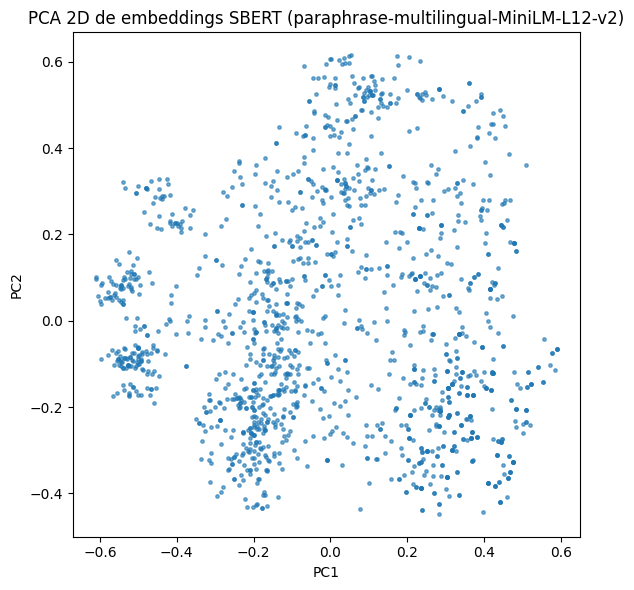

In [29]:

sample_n = min(1500, emb_corpus.shape[0])
idx_s = np.random.choice(emb_corpus.shape[0], size=sample_n, replace=False)
Z = emb_corpus[idx_s]

pca = PCA(n_components=2, random_state=RNG_SEED)
Z2 = pca.fit_transform(Z)

plt.figure(figsize=(6,6))
plt.scatter(Z2[:,0], Z2[:,1], s=6, alpha=0.6)
plt.title(f"PCA 2D de embeddings SBERT ({modelo})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig("out/pca_embeddings_2d.png", dpi=160)
plt.show()



# Guardar métricas y reproducibilidad

In [30]:
results = {
    "seed": RNG_SEED,
    "n_corpus": int(len(oraciones)),
    "n_queries": int(len(consultas)),
    "valid_queries_exact_match": int(valid_mask.sum()),
    "recall10_tfidf_exact": float(recall10_tfidf),
    "recall10_emb_exact": float(recall10_emb),
    "model_name": modelo,
}
with open("out/metrics.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)

print("Métricas guardadas en out/metrics.json")


Métricas guardadas en out/metrics.json
